In [1]:
import os
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from SiameseModel import Recognizer
from matplotlib import pyplot as plt

RAW_DATA_DIR = r'/work/martiks/PMData'
PARTICIPANTS = os.listdir(RAW_DATA_DIR)
PARTICIPANTS = [p for p in PARTICIPANTS if ".xlsx" not in p] # Not including the .xlsx file
MAX_DAYS = 98 # 14 weeks
CHUNK_SIZE = 17280

NUM_PARTICIPANTS = 16
assert (1 <= NUM_PARTICIPANTS <= 16), "Number of participants must be between 1-16"

NUM_DAYS = 50
assert_msg = f"Number of days must be between 1-{MAX_DAYS}"
assert (1 <= NUM_DAYS <= MAX_DAYS), assert_msg

START_DAY = 0
assert_msg = f"Start day index must be <= {MAX_DAYS - NUM_DAYS}"
assert (START_DAY <= (MAX_DAYS - NUM_DAYS)), assert_msg

TEST_NUM_DAYS = 20
assert_msg = f"Number of test days must be <= {MAX_DAYS - (START_DAY + NUM_DAYS)}"
assert (TEST_NUM_DAYS <= (MAX_DAYS - (START_DAY + NUM_DAYS))), assert_msg

TEST_START_DAY = START_DAY + NUM_DAYS

print("======================================================TEST START======================================================")
print(f"Parameters used: num_participants={NUM_PARTICIPANTS}, num_days={NUM_DAYS}, start_day={START_DAY}, test_num_days={TEST_NUM_DAYS}, test_start_day={TEST_START_DAY}")

======================================================TEST START======================================================
Parameters used: num_participants=16, num_days=50, start_day=0, test_num_days=20, test_start_day=50


In [2]:
def read_file(maindir, p, file):
    path = f"{maindir}/{p}/fitbit/{file}"
    if ".json" in file:
        return pd.read_json(path)
    elif ".csv" in file:
        return pd.read_csv(path) # TODO: verify that pandas reads the PMData csv files properly
    else:
        raise TypeError("Unsupported file type!")


def clean_data_hr(df, start_date="2019-11-18 00:00:00", end_date="2020-02-23 23:59:59"):
    # Preserve datetime as index
    df['dateTime'] = pd.to_datetime(df['dateTime'])
    index = df['dateTime']
    
    # Convert dict-values to columns and set datetimes as index
    df = pd.DataFrame.from_dict(df.value.to_dict(), orient='index')
    df = df.set_index(index)

    # Check if start_date and end_date rows exist (create if not)
    if not start_date in df.index:
        stamp = pd.Timestamp(start_date)
        df.loc[stamp] = None
    if not end_date in df.index:
        stamp = pd.Timestamp(end_date)
        df.loc[stamp] = None
    
    # Sort chronologically using datetime-index
    df = df.sort_index()

    # Shave off incomplete weeks at start/end
    df = df.loc[start_date:end_date] # Adjust dates as necessary

    # Fill in missing rows to make data set consistent (secondly)
    df = df.resample('1s').first()

    # Interpolate, round off and cast to int
    df['bpm'] = df.bpm.interpolate(method='linear', limit_direction='both').round(0).astype(np.int32)
    
    # Resample back to 5-second frequency
    df = df.resample('5s').first()

    # Add day of the week features
    df = df.reset_index()
    df['weekday'] = df['dateTime'].dt.dayofweek
    df['mon'] = df['weekday'].apply(lambda x: 1 if (x==0) else 0)
    df['tue'] = df['weekday'].apply(lambda x: 1 if (x==1) else 0)
    df['wed'] = df['weekday'].apply(lambda x: 1 if (x==2) else 0)
    df['thu'] = df['weekday'].apply(lambda x: 1 if (x==3) else 0)
    df['fri'] = df['weekday'].apply(lambda x: 1 if (x==4) else 0)
    df['sat'] = df['weekday'].apply(lambda x: 1 if (x==5) else 0)
    df['sun'] = df['weekday'].apply(lambda x: 1 if (x==6) else 0)

    # Remove unwanted columns
    del df['dateTime']
    del df['confidence']
    del df['weekday']
    
    return df

In [3]:
def prepare_chunks(datasets, chunk_size, start_day=0, days=5, no_ID=False):
    # List with participant name and corresponding day-chunks
    # [('p01', chunks), ('p02', chunks), ...]
    chunks = []
    start_ind = start_day * chunk_size # Finds index corresponding to timestamp 00:00:00 of start_day
    for p in datasets:
        for i in range(days):
            from_ind = start_ind + (chunk_size * i)
            to_ind = from_ind + (chunk_size - 1)
            chunk = p[1].loc[from_ind:to_ind]
            chunk = np.array(chunk)
            if no_ID:
                chunks.append(chunk)
            else:
                chunks.append((p[0], chunk))

    return chunks

In [4]:
# BALANCED VERSION
def balanced_sets(chunks):
    input_1 = []
    input_2 = []

    # Match all chunks (balanced 50/50 split)
    for i in range(len(chunks)):
        same = []
        not_same = []
        for j in range(len(chunks)):
            if chunks[j][0] == chunks[i][0]:
                same.append(chunks[j])
            else:
                not_same.append(chunks[j])
        random.shuffle(same)
        random.shuffle(not_same)
        not_same = not_same[:len(same)] # match lengths for balance
        to_add = same + not_same
        random.shuffle(to_add)
        input_2.extend(to_add)
        for x in range(len(to_add)):
            input_1.append(chunks[i])
    
    return input_1, input_2

In [5]:
# GENERATE LABELS AND REMOVE ID
def remove_ID(dataset):
    """
    WARNING: Will modify inputs.
    """
    for i in range(len(dataset)):
        dataset[i] = dataset[i][1]

def generate_labels(input_1, input_2):
    labels = []
    for i in range(len(input_1)):
        # Check if they have the same ID
        p1 = input_1[i][0]
        p2 = input_2[i][0]
        if p1 == p2:
            labels.append(1)
        else:
            labels.append(0)
    remove_ID(input_1)
    remove_ID(input_2)

    return labels

In [6]:
def prepare_inputs(start_index, length, size):
    chunks = prepare_chunks(datasets, size, start_day=start_index, days=length)
    x1, x2 = balanced_sets(chunks)
    y = generate_labels(x1, x2)
    X1 = np.array(x1)
    X2 = np.array(x2)
    Y = np.array(y)
    
    return X1, X2, Y

In [7]:
# DATA PROCESSING

datasets = []
for p in PARTICIPANTS:
    pdata = read_file(RAW_DATA_DIR, p, "heart_rate.json")
    d = clean_data_hr(pdata)
    tup = (p, d)
    datasets.append(tup)

In [8]:
X1, X2, Y = prepare_inputs(START_DAY, NUM_DAYS, CHUNK_SIZE)

chunk_len = len(X1)
train_len = int(chunk_len * 0.7)
X1_train = X1[:train_len]
X1_val = X1[train_len:]
X2_train = X2[:train_len]
X2_val = X2[train_len:]
Y_train = Y[:train_len]
Y_val = Y[train_len:]

In [9]:
# MODEL TRAINING

recognizer = Recognizer()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

checkpoint_filepath_loss = '/work/martiks/saved_model/loss'
save_checkpoint_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_loss,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True
)

checkpoint_filepath_val_loss = '/work/martiks/saved_model/val_loss'
save_checkpoint_val_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_val_loss,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

parameters = {
    'batch_size': 16,
    'epochs': 5000,
    'callbacks': [early_stop, save_checkpoint_loss, save_checkpoint_val_loss],
    'val_data': ([X1_val, X2_val], Y_val)
}

history = recognizer.fit([X1_train, X2_train], Y_train, hyperparameters=parameters)

Epoch 1/5000
3500/3500 [==============================] - ETA: 0s - loss: 2.5964 - accuracy: 0.7609WARNING:tensorflow:From /work/martiks/tfpy/lib/python3.8/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /work/martiks/saved_model/loss/assets
INFO:tensorflow:Assets written to: /work/martiks/saved_model/val_loss/assets
3500/3500 [==============================] - 445s 127ms/step - loss: 2.5964 - accuracy: 0.7609 - val_loss: 0.7223 - val_accuracy: 0.6611
Epoch 2/5000
3500/3500 [==============================] - 398s 114ms/step - loss: 0.4750 - accuracy: 0.8356 - val_loss: 0.8205 - val_a

In [10]:
# TESTING

def print_scores(scores, truths):
    passed = 0
    for i in range(len(scores)):
        truth = truths[i]
        score = scores[i]
        test = "FAILED"
        if (truth == 0) and (0 <= score < 0.5):
            test = "PASSED"
            passed += 1
        elif (truth == 1) and (0.5 <= score <= 1):
            test = "PASSED"
            passed += 1
        print(f"Test {i} ground truth: {truth}, predicted score: {score}, test: {test}")
    print(f"Passed {passed} of {len(scores)} tests.")

In [11]:
# Load saved best model
loaded_recognizer = tf.keras.models.load_model('/work/martiks/saved_model/val_loss')

In [12]:
# BALANCED TEST
t1, t2, truths = prepare_inputs(TEST_START_DAY, TEST_NUM_DAYS, CHUNK_SIZE)
scores = loaded_recognizer.predict([t1, t2])

In [13]:
print_scores(scores, truths)

Test 0 ground truth: 1, predicted score: [0.7745746], test: PASSED
Test 1 ground truth: 1, predicted score: [0.7846372], test: PASSED
Test 2 ground truth: 0, predicted score: [0.06025311], test: PASSED
Test 3 ground truth: 1, predicted score: [0.47482178], test: FAILED
Test 4 ground truth: 1, predicted score: [0.7846084], test: PASSED
Test 5 ground truth: 1, predicted score: [0.7846374], test: PASSED
Test 6 ground truth: 0, predicted score: [0.784637], test: FAILED
Test 7 ground truth: 0, predicted score: [0.04068767], test: PASSED
Test 8 ground truth: 1, predicted score: [0.7709205], test: PASSED
Test 9 ground truth: 1, predicted score: [0.56950337], test: PASSED
Test 10 ground truth: 0, predicted score: [0.34856898], test: PASSED
Test 11 ground truth: 0, predicted score: [0.09991308], test: PASSED
Test 12 ground truth: 0, predicted score: [0.10042752], test: PASSED
Test 13 ground truth: 1, predicted score: [0.765351], test: PASSED
Test 14 ground truth: 0, predicted score: [0.0686436]

=======================================================TEST END=======================================================


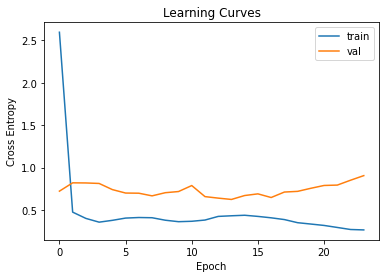

In [14]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.savefig('learning_curve.png')

print("=======================================================TEST END=======================================================")